# <center> <div align="center"> PySensMCDA - Literature example <div/>
<br/>

**Note**: *this notebook was created for the purpose of providing an example usage of the library for sensitivity analysis of decision-making problem, this should be taken only as an example, as it does not provide in-depth description and conclusions* 

For general examples see [`examples.ipynb`](./examples.ipynb)<br/>
For graphs usage examples see [`graphs_examples.ipynb`](./graphs_examples.ipynb)

<br/>

**This example is based on decision matrix from**:

[Mousavi-Nasab, S. H., & Sotoudeh-Anvari, A. (2018). A new multi-criteria decision making approach for sustainable material selection problem: A critical study on rank reversal problem. Journal of Cleaner Production, 182, 466-484.](https://www.sciencedirect.com/science/article/abs/pii/S0959652618303688)

In [1]:
from pysensmcda import alternative, criteria, compromise, graphs, probabilistic, ranking, calculate_preference
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import Matrix
from IPython.display import display, Markdown

In [3]:
matrix = np.array([[2700, 0.03, 4, 3, 2.32],
[2700, 0.03, 4, 3, 2.3],
[7900, 0.03, 3, 5, 0.85],
[4500, 0.02, 5, 3, 13],
[8900, 0.02, 5, 4, 6],
[6000, 0.02, 3, 1, 2.2],
[8930, 0.02, 5, 5, 2.3]])
display(Markdown('**Initial decision matrix:**'))
display(Matrix(matrix))

**Initial decision matrix:**

Matrix([
[2700.0, 0.03, 4.0, 3.0, 2.32],
[2700.0, 0.03, 4.0, 3.0,  2.3],
[7900.0, 0.03, 3.0, 5.0, 0.85],
[4500.0, 0.02, 5.0, 3.0, 13.0],
[8900.0, 0.02, 5.0, 4.0,  6.0],
[6000.0, 0.02, 3.0, 1.0,  2.2],
[8930.0, 0.02, 5.0, 5.0,  2.3]])

In [4]:
alt_num, crit_num = matrix.shape

For the analysis monte carlo weights are calculated, as assigning weights is one of the most crucial processes during decision-making and it can often provide completely different resulting ranking. Such approach presents what would happen if random weights were assigned and how much can it affect final ranking.

In [5]:
monte_carlo_weights = probabilistic.monte_carlo_weights(5)

As 1000 different weights vectors were generated, we can visualize the distribution of values for weights for given criterion. This can be done using `multi_hist_dist()`.

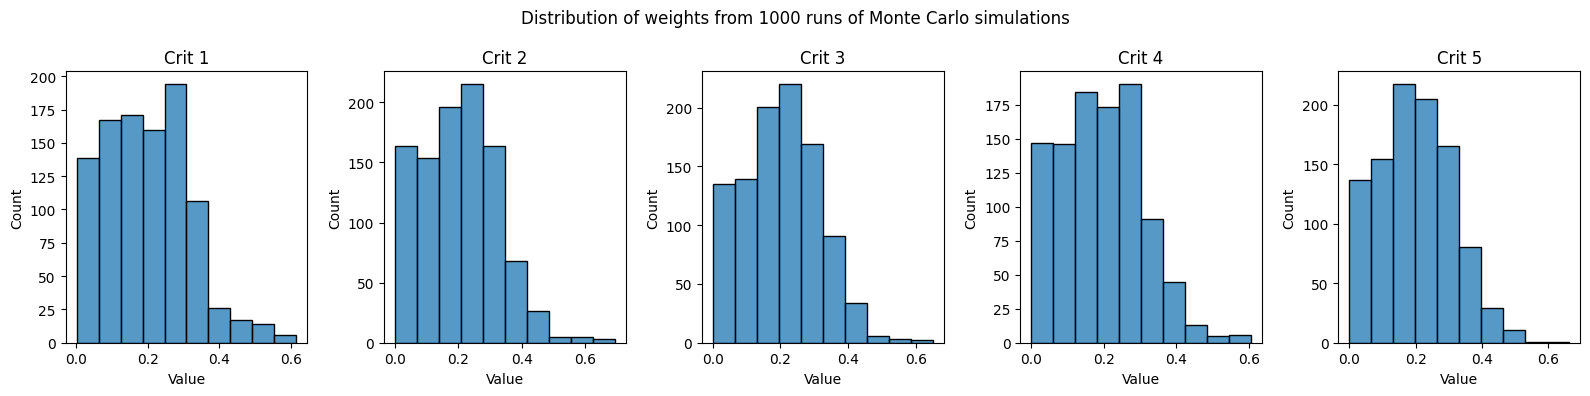

In [6]:
# In the case of using sliders, the reference should be kept, so Python wouldn't GC
graphs.multi_hist_dist(monte_carlo_weights, kind='hist', title_pos=0.5, nrows=1, ncols=5, figsize=(16, 4), show_slider=False, title='Distribution of weights from 1000 runs of Monte Carlo simulations', bins_count= 10)
plt.show()

With many weights vectors present, it is impossible to calculate single ranking. So for further analysis we can use fuzzy ranking, which will present how rankings differ when calculated using different weights.

In [7]:
from pymcdm.methods import TOPSIS

topsis = TOPSIS()

kwargs = {
    'matrix': matrix,
    'types': [-1, 1, 1, 1, -1]
}

rankings = calculate_preference(probabilistic.monte_carlo_weights, monte_carlo_weights, topsis, kwargs, method_type=1)[:, 1]
fuzzy_rank = ranking.fuzzy_ranking(rankings, normalization_axis=0)
display(Markdown('**Resulting fuzzy ranking**:'))
display(Matrix(fuzzy_rank))

**Resulting fuzzy ranking**:

Matrix([
[     0,    1.0, 0.2285, 0.0945,      0,      0, 0.3216],
[   1.0, 0.1846, 0.0452, 0.0293, 0.2062,      0, 0.0768],
[0.1846, 0.1189,    1.0, 0.6124, 0.0711, 0.0171, 0.2324],
[0.1189, 0.0867, 0.2421, 0.4039,  0.173, 0.1044,    1.0],
[0.0867, 0.0084, 0.2557, 0.4495,    1.0, 0.1713, 0.3091],
[0.0084,      0, 0.4389,    1.0, 0.6137, 0.2648, 0.1328],
[     0,      0,  0.052, 0.6678, 0.3057,    1.0, 0.0021]])

We can then visualize the resulting fuzzy ranking for easier analysis.

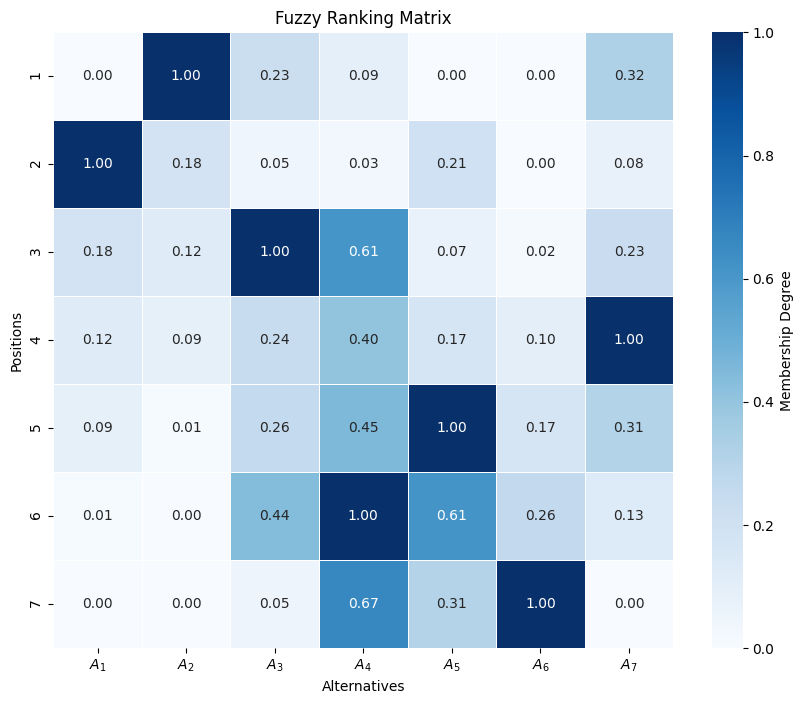

In [8]:
graphs.heatmap(fuzzy_rank, title="Fuzzy Ranking Matrix", figsize=(10, 8))
plt.show()

This let us decide which ranking is the most common for given set of alternatives, however more in-depth information might be needed. For such cases, additionally we can visualize rankings distribution.

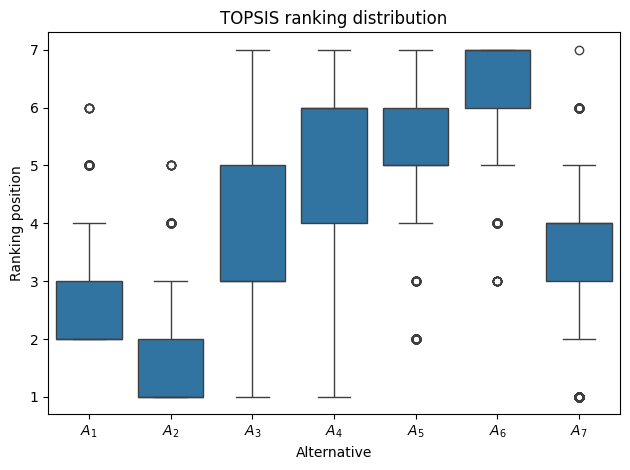

In [9]:
graphs.rankings_distribution(rankings, title='TOPSIS ranking distribution', show_legend=False, xlabel='Alternative', ylabel='Ranking position')
plt.show()

Let us further consider the most common ranking.

In [10]:
most_common_r = np.argmax(fuzzy_rank, axis=0)+1
display(Markdown('**Most common ranking**:'))
display(Matrix(most_common_r).T)

**Most common ranking**:

Matrix([[2, 1, 3, 6, 5, 7, 4]])

This approach presents more in-depth analysis of possible outcome. However sometimes an analysis of already calculated problem is needed. For this let us consider one presented in cited paper.

In [11]:
weights = np.array([0.4, 0.1, 0.1, 0.1, 0.3])
initial_ranking = np.array([2, 1, 6, 3, 7, 5, 4])
display(Markdown('**Weights considered in cited paper**:'))
display(Matrix(weights).T)
display(Markdown('**TOPSIS ranking considered in cited paper**:'))
display(Matrix(initial_ranking).T)

**Weights considered in cited paper**:

Matrix([[0.4, 0.1, 0.1, 0.1, 0.3]])

**TOPSIS ranking considered in cited paper**:

Matrix([[2, 1, 6, 3, 7, 5, 4]])

We can then analyze ranking demotion to see what kind of changes could influence resulting ranking.

In [12]:
call_kwargs = {
    "matrix": matrix,
    'weights': weights,
    'types': [-1, 1, 1, 1, -1]
}

ranking_descending = True
direction = np.array([1, -1, -1, -1, 1])
step = 0.5
max_modification = 10
results = ranking.ranking_demotion(matrix, initial_ranking, topsis, call_kwargs, ranking_descending, direction, step, max_modification=max_modification)

print('Initial ranking:')
display(Matrix(initial_ranking).T)
print(f'Example result (1/{len(results)}):\n')
print(f'Alternative index: {results[0][0]}')
print(f'Criterion index: {results[0][1]}')
print(f'Size of change: {results[0][2]}')
print(f'New position: {results[0][3]}')

Initial ranking:


Matrix([[2, 1, 6, 3, 7, 5, 4]])

Example result (1/35):

Alternative index: 0
Criterion index: 0
Size of change: 11182.0
New position: 7


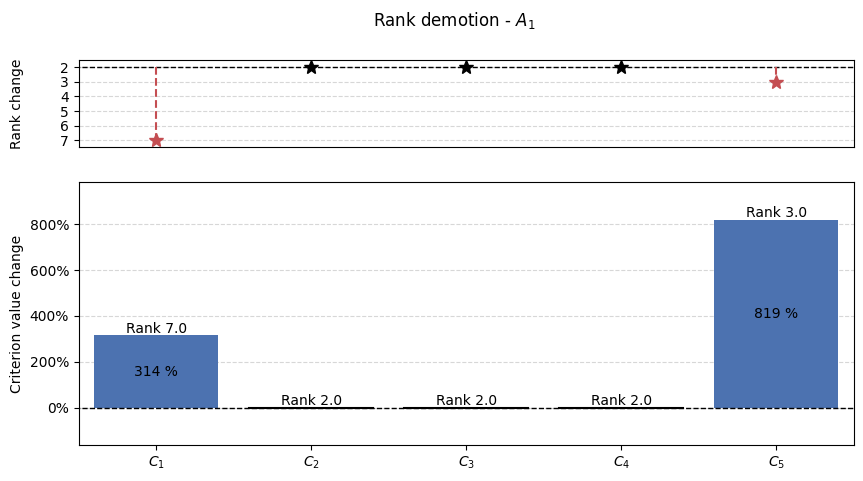

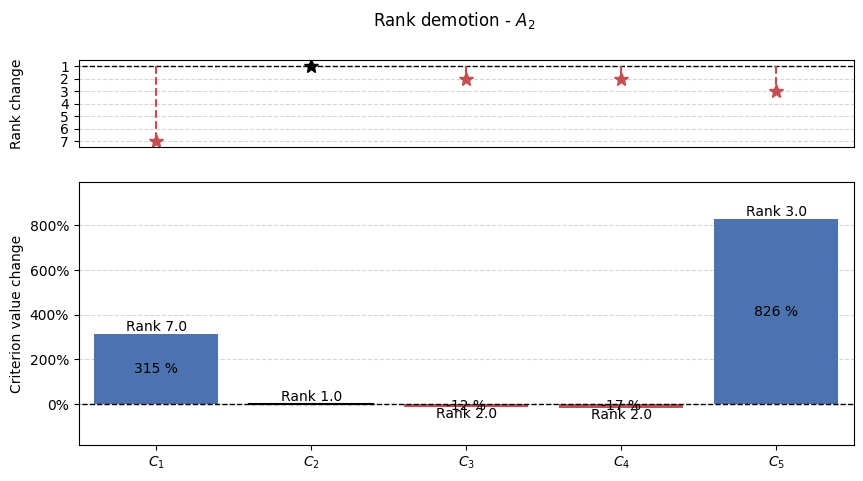

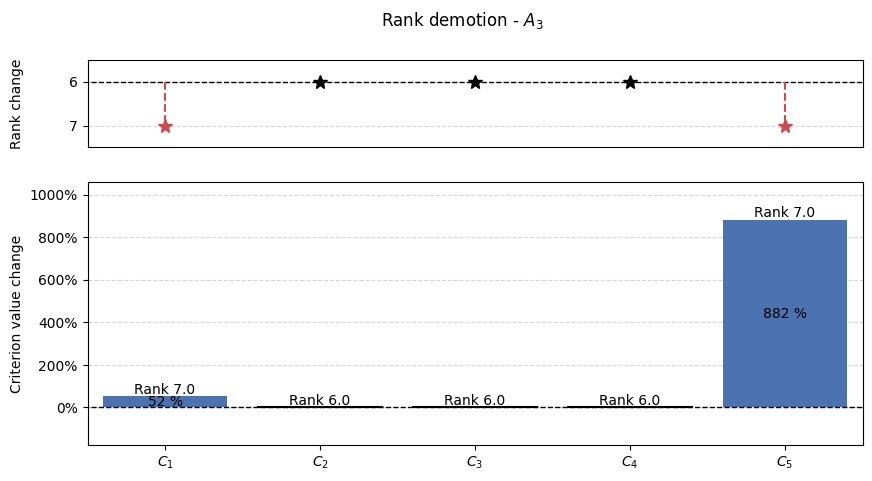

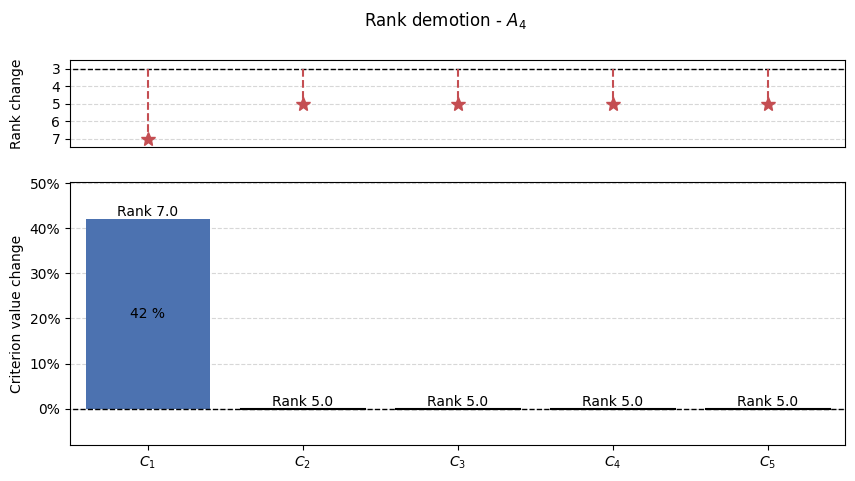

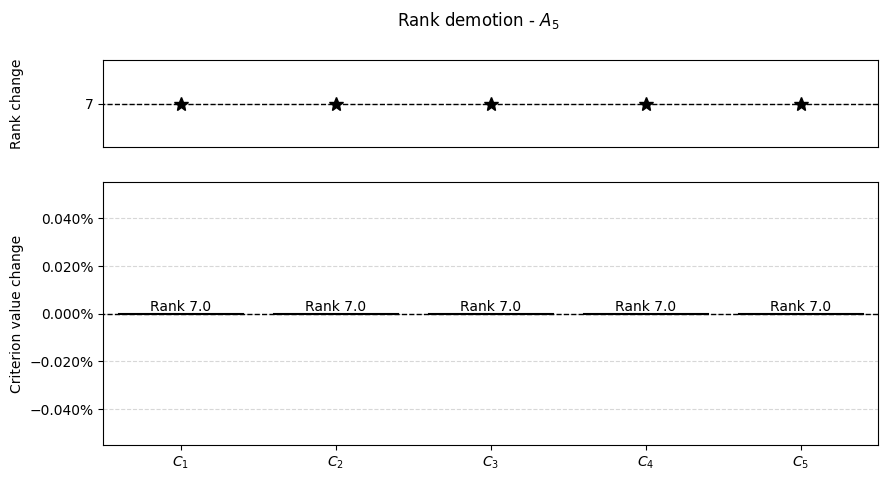

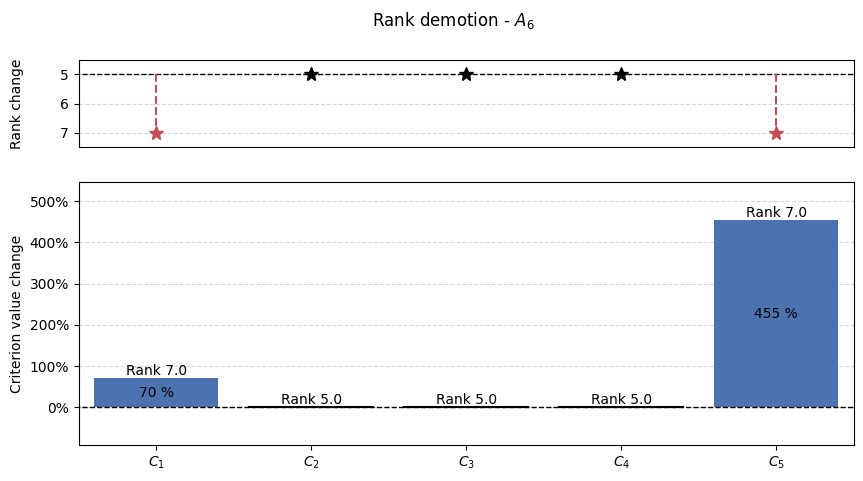

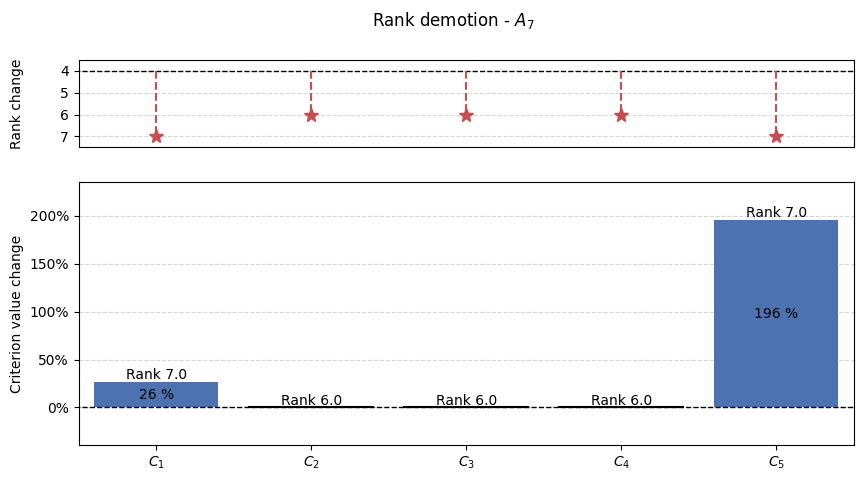

In [13]:
plt.rcParams['figure.figsize'] = (10, 5)
results = np.array(results)
for alt in range(matrix.shape[0]):
    alt_results = results[results[:, 0] == alt]
    percentage_changes = []
    new_positions = []
    if len(alt_results):
        for crit in range(matrix.shape[1]):
            r = alt_results[alt_results[:, 1] == crit]
            if len(r):
                _ , crit, change, new_pos = r[0]
                crit = int(crit)
                if initial_ranking[alt] == new_pos:
                    percentage_changes.append(0)
                else:
                    percentage_changes.append((change - matrix[alt, crit])/matrix[alt, crit]*100)
                new_positions.append(new_pos)
            else:
                percentage_changes.append(0)
                new_positions.append(initial_ranking[alt])
        graphs.pd_rankings_graph(initial_ranking[alt], new_positions, np.array(percentage_changes), kind='bar', title=f'Rank demotion - $A_{{{alt+1}}}$')